In [1]:
# general import
import os
import pickle
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import copy

# torch
import torch
import torch.nn as nn
import torch.optim as optim

# my own
from tasks import get_data
from myutils import *
from topology import gen_lattice, compute_dist

# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

dtype = torch.float
device = torch.device("cpu")

# SOME USEFUL DEFINITIONS
relu = lambda x : (x > 0) * x
def pr(h, b):
    if b > 1e2:
        return 1. * (h > 0)
    else:
        return np.exp(b * h) / (2 * np.cosh(b * h))

/tmp/ipykernel_35013/1108169760.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Set task

### Available task:

Random Tasks:
- __RANDOM__ : random iid gaussian inputs mapped to random binary outputs
- __RANDOM-Y__ : random iid gaussian inputs mapped to random gaussian outputs
- __NLGP__ : spatially correlated inputs with output labels defined by their correlation length
- __RANDOM-FF-Teacher__: random Feed Forward teacher networkm with two layers with binary output
- __RANDOM-FF-Teacher-Y__: random Feed Forward teacher network with two layers with continuous output
- __RANDOM-RNN-Teacher__ : random Recurrent teacher network with binary output
- __RANDOM-RNN-Teacher-X__ : random Recurrent teacher network targets defined as steady state activities
- __RANDOM-RNN-Teacher-Y__ : random Recurrent teacher network with continuous output


Datasets:
- __MNIST1D__
- __MNIST__
- __MNIST10__
- __FashionMNIST__
- __CIFAR10__
- __CIFAR100__

In [2]:
# SET MAIN PARAMS

pars = Pars()

## random task name
# pars.dataset = "RANDOM"
# pars.dataset = "RANDOM-Y"
pars.dataset = "NLGP"
# pars.dataset = "RANDOM-FF-Teacher"
# pars.dataset = "RANDOM-FF-Teacher-Y"
# pars.dataset = "RANDOM-RNN-Teacher"
# pars.dataset = "RANDOM-RNN-Teacher-X"
# pars.dataset = "RANDOM-RNN-Teacher-Y"

## dataset name
# pars.dataset = "MNIST1D"
# pars.dataset = "MNIST"
# pars.dataset = "MNIST10"
# pars.dataset = "FashionMNIST"
# pars.dataset = "CIFAR10"
# pars.dataset = "CIFAR100"

## random dataset options
pars.alpha_train = 0.1 # fraction of training patterns wrt N in a random task
pars.alpha_test = 0.1 # fraction of test patterns wrt N in a random task
pars.span_h = False # generate all h in range (only makes sense for N=2 or N=3)
pars.exp_input = False # exponentially distributed input (default is gaussian)
pars.rho = 0. # input covariance

## teacher-student FF options
pars_teacher = {}
# pars_teacher["K"] = 1 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "linear" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = True # constant output weights
# pars_teacher["num_out"] = 1 # number of output units 
# pars_teacher["g"] = 1. # gain of ff weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

# ## teacher-student RNN options
# pars_teacher = {}
# pars_teacher["K"] = 40 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "relu" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["discrete_time"] = False # type of temporal dynamics
# pars_teacher["dt"] = 0.1 # time discretization
# pars_teacher["eye_in"] = True # identity input weights
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = False # constant output weights
# pars_teacher["num_out"] = 1 # number of output units 
# pars_teacher["g"] = 0.8 # gain of recurrent weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

## NLGP specific options
pars.torus = True # whether to use a torus topology
pars.g_nonlin = 1e-10 # gain parameter for nonlinearity
pars.xis = [2] # lenght-scales of mixtures

## spatial options
pars.dim = 1 # input dimension
pars.lN = 100 # linear input dimension
pars.normalize = False # normalize inputs (some dataset are already normalized)

## misc options
pars.seed_data = 1
pars.data_dir = f'data'
pars.save_dir = f'results_notebook'

# # TO DIRECTLY DOWNLOAD MNIST1D USE THE FOLLOWING:
# import requests
# url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
# r = requests.get(url, allow_redirects=True)
# save_dir_dataset = save_dir + "/" + dataset
# open(f'{data_dir}/mnist1d_data.pkl', 'wb').write(r.content)

In [3]:
# GET DATASET
makedir(pars.data_dir)
data_and_properties = get_data(pars, dtype=dtype, device=device)
train_dataset, test_dataset, teacher_weights, x_teacher = data_and_properties
print(f"{pars.dim} dimensional inputs of size {pars.lN}^{pars.dim} = {pars.N}")
print(f"num train: {pars.num_train}, num test: {pars.num_test}, num label: {pars.num_label}")

1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 10, num label: 1


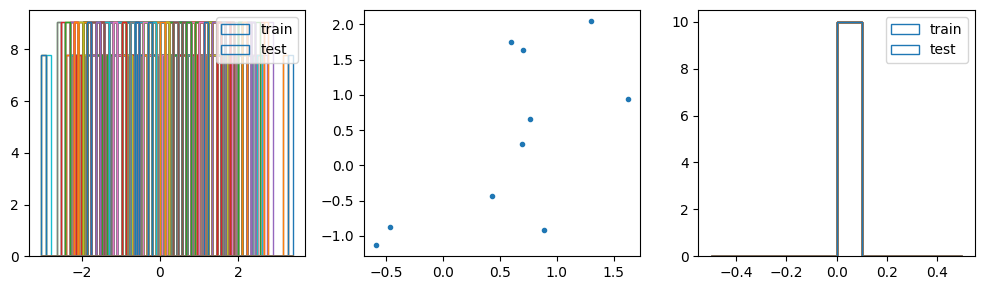

In [4]:
# WATCH RANDOM DATA DISTRIBUTION

if "RANDOM" in pars.dataset or "GP" in pars.dataset:
    plt.figure(figsize=(10,3))

    X_to_plot_train, y_to_plot_train = extract_tensors(train_dataset)
    if pars.num_test is not None:
        X_to_plot_test, y_to_plot_test = extract_tensors(test_dataset)

    plt.subplot(131)
    plt.hist(X_to_plot_train.flatten(), bins=50, density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(X_to_plot_test.flatten(), bins=50, density=True, histtype="step", label="test");
    plt.legend();

    plt.subplot(132)
    plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,1], '.');
#     plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,2], '.');

    plt.subplot(133)
    plt.hist(y_to_plot_train.flatten(), density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(y_to_plot_test.flatten(), density=True, histtype="step", label="test");
    plt.legend();

    plt.tight_layout()

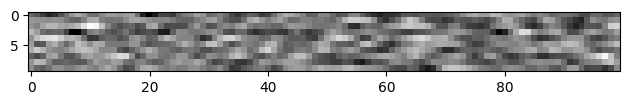

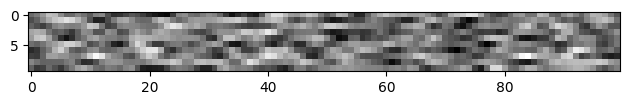

In [5]:
# WATCH DATASET
watch_dataset(train_dataset, test_dataset, pars)

## Run learning

In [6]:
# network options
lN, N = pars.lN, pars.N
P = pars.num_train
fe = -1
sparsity_mean = 0.
sparsity_std = 0.
noself = True
use_bias = True
learn_bias = True
bias = 0.
norm_dependent_stability = False
embed_model = False
dim = pars.dim
torus = pars.torus

# learning options
num_epochs = 200
print_every = 10
lr = 0.1
delta0 = 0.1
gam = 0.
gam_en = 0.
gam_sign = 0.5
gam_pos = 0.
relu2 = True
maxweight = 1e2
square_dist = False
stop_at_zero_err = False

# ## homogeneous sparsities
# sparsities = sparsity_mean + np.random.randn(N) * sparsity_std
# sparsities = np.clip(sparsities, a_min=0, a_max=1)
# ## space-dependent sparsities
# sparsities = np.linspace(0.9, 0.1, N)
# sparsities = np.ones(N) * 0.95
# sparsities[:N//2] = 0.15

# gen patterns
# X = 1. * (np.random.rand(P,N) <= sparsities[None])
X = 0.5 * (1 + np.sign(train_dataset.tensors[0].numpy()))
Y = 2. * X - 1.

# if sparsity_std > 0:
#     plt.plot(sparsities, '.:')
#     plt.plot(X.mean(0), '.-')
#     plt.title('sparsities');
    
## init J
Ne = int(fe * N)
I = bias * np.ones(N)
if fe == -1:
    J = np.random.randn(N, N) / np.sqrt(N)
else:
    J = np.random.rand(N, N) / np.sqrt(N)
    J[:,Ne:] *= -1.
diag_indices = np.diag_indices(N)
if noself:
    J[diag_indices] = 0.

## generate positions    
if embed_model:
    if dim == 1:
        L = N
        totpoints = [L]
    elif dim == 2:
        L = int(np.sqrt(N))
        if L**2 != N:
            print("WARNING: need a perfect square in dimension 2")
        totpoints = [L, L]
    else:
        raise ValueError("dim = 3 not implemented yet!")

    pos = gen_lattice(dim=dim, lens=[L,L], torus=torus, random_pos=False, tot_points=totpoints, centered=False)
    dist = compute_dist(dim, pos, pos, lens=[L,L], torus=torus, square=square_dist)
    # dist = np.tanh(dist/10) * 10
    pos = pos.numpy()
    dist = dist.numpy()

    # visualize positions
    if dim == 1:
        plt.plot(pos, 0 * np.ones_like(pos), 'o', ms=1)
        plt.title('positions')
        plt.show()

        # recurrent reg
        i_plot = [L//2]
        for i in i_plot:                
            plt.plot(pos[i], 0, 'o')
            plt.plot(pos, dist[i], '.-')
        plt.title('recurrent reg')
        plt.show()

In [7]:
# init containers
J0 = J.copy()
errs, en_regs, sign_regs, pos_regs = [], [], [], []

# run optimization    
ok = False
for ep in range(num_epochs):
    
    # run through data
    perm = np.random.permutation(P)
    for mu in perm:
        
        # compute fields
        H = J @ X[mu]
        if use_bias:
            H += I
            
        # learning step
        delta = delta0 * np.sqrt((J**2).sum(-1)) if norm_dependent_stability else delta0 * np.sqrt(N)
        err = Y[mu] * ((Y[mu] * H) < delta)
        derr = np.outer(err, X[mu])
        J += lr * derr
        J -= lr * gam * J
        
        # train input bias
        if use_bias and learn_bias:
            I += lr * err
        
        # apply energy regularization
        if gam_en:
            en_reg = 0.5 * (J**2 @ X[mu]).mean()
            J -= lr * gam_en * J * X[mu][None]
        
        # apply sign regularization
        if gam_sign:
            if relu2:
                reluscorr = relu(-np.einsum('ki,li->kli', J, J))
                sign_reg = 0.25 * (reluscorr**2).sum() / N**2
                dsign_reg = -np.einsum('kli,li->ki' ,reluscorr, J)
            else:
                scorr = -np.einsum('ki,li->kli', J, J)
                thetascorr = 1. * (scorr >= 0)            
                sign_reg = 0.5 * (thetascorr * scorr).sum() / N**2
                dsign_reg = -np.einsum('ijk,ji->ik', thetascorr, J)
            J -= lr * gam_sign * dsign_reg
            
        # apply position regularization
        if gam_pos:
            J -= lr * gam_pos * J * dist
                        
        # enforce constraints
        if Ne > -1:
            np.clip(J[:,:Ne], 0., maxweight, out=J[:,:Ne])
            np.clip(J[:,Ne:], -maxweight, 0., out=J[:,Ne:])
        if noself:
            J[diag_indices] = 0.
                        
    # compute errors and print
    if ep % print_every == 0:
        
        # compute loss on entire training set
        Hs = X @ J.T
        if use_bias:
            Hs += I[None]
        err = ((Hs * Y) < delta).mean()
        errs += [err]
        
        # compute en reg
        if gam_en:
            en_reg = 0.5 * (X @ J**2).mean()
            en_regs += [en_reg]
        
        # compute sign reg on J
        if gam_sign:
            reluscorr = relu(-np.einsum('ik,jk->ijk', J, J))
            if relu2:
                sign_reg = 0.25 * (reluscorr**2).sum() / N**2
            else:
                sign_reg = 0.5 * reluscorr.sum() / N**2
            sign_regs += [sign_reg]
        
        if gam_pos:
            pos_reg = 0.5 * (J**2 * dist).mean()
            pos_regs += [pos_reg]
        
        # print info
        toprint = f'ep: {ep} loss: {err}'
        if gam_en:
            toprint += f' en reg: {en_reg}'
        if gam_sign:
            toprint += f' sign reg: {sign_reg}'
        if gam_pos:
            toprint += f' pos reg: {pos_reg}'
        print(toprint)
        
        # optionally stop at convergence
        if err.sum() == 0:
            if not ok:
                ep_conv = ep
                ok = True
            if stop_at_zero_err:
                break
                
if not ok:
    print(f'loss not zero in {ep} epochs - min av error {errs[-1]}')
else:
    print(f'zero loss converged at {ep_conv} epochs')

ep: 0 loss: 0.383 sign reg: 0.0032171239272291894
ep: 10 loss: 0.16 sign reg: 0.0010398543373167431
ep: 20 loss: 0.008 sign reg: 7.281976051596917e-05
ep: 30 loss: 0.0 sign reg: 1.0978335892608108e-06
ep: 40 loss: 0.0 sign reg: 1.1498511223767417e-07
ep: 50 loss: 0.0 sign reg: 7.118902202875878e-08
ep: 60 loss: 0.0 sign reg: 2.8410322231234027e-08
ep: 70 loss: 0.0 sign reg: 1.404917660820425e-08
ep: 80 loss: 0.0 sign reg: 7.374957375208164e-09
ep: 90 loss: 0.0 sign reg: 3.992427730253716e-09
ep: 100 loss: 0.0 sign reg: 2.1974704169925405e-09
ep: 110 loss: 0.0 sign reg: 1.2205865803431684e-09
ep: 120 loss: 0.0 sign reg: 6.814140539603081e-10
ep: 130 loss: 0.0 sign reg: 3.8148663087722584e-10
ep: 140 loss: 0.0 sign reg: 2.139112146992807e-10
ep: 150 loss: 0.0 sign reg: 1.2005282139838583e-10
ep: 160 loss: 0.0 sign reg: 6.741041574996275e-11
ep: 170 loss: 0.0 sign reg: 3.786193591030481e-11
ep: 180 loss: 0.0 sign reg: 2.1268981038107827e-11
ep: 190 loss: 0.0 sign reg: 1.194892356071828e-1

In [8]:
display(J>1e-1)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

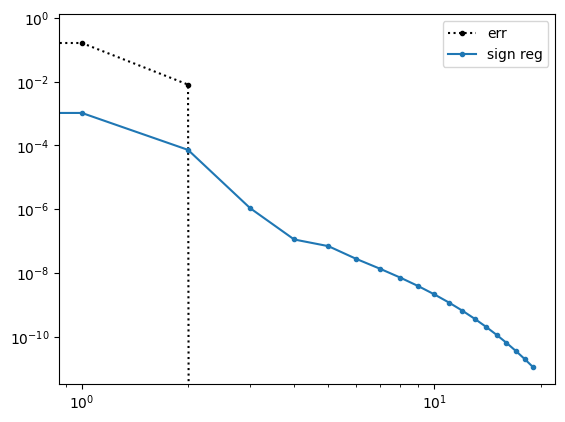

In [9]:
plt.plot(errs, '.:', c='black', label='err');
if gam_en:
    plt.plot(en_regs, '.-', label='en reg');
if gam_sign:
    plt.plot(sign_regs, '.-', label='sign reg');
if gam_pos:
    plt.plot(pos_regs, '.-', label='pos reg');
plt.legend();
    
plt.xscale('log');
plt.yscale('log');

## Check stability of attractors by running network dynamics

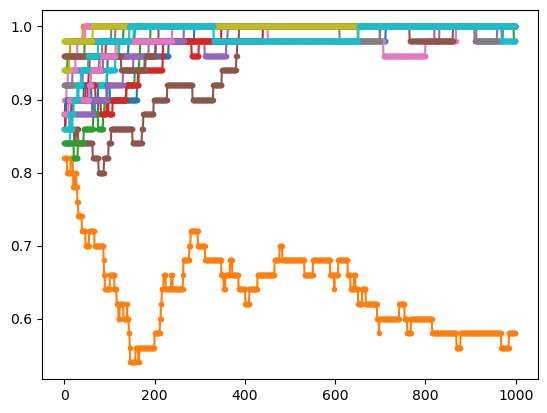

In [9]:
# set pars
mu = 0
num_samples = 20
beta = 20
num_iter = 1000
p_flip = 0.05

# init network
x = np.tile(X[mu], num_samples).reshape(num_samples, N)
flip_init = np.random.rand(num_samples, N) <= p_flip
x[flip_init] = 1 - x[flip_init]

# run dynamics
xs = np.zeros((num_iter, num_samples, N))
for it in range(num_iter):
    xs[it] = x.copy()
    h = x @ J.T + I[None]
    select = np.random.randint(N, size=num_samples)
    prob = pr(-(2. * x[range(num_samples), select] - .1) * h[range(num_samples), select], beta)
    toflip = np.random.rand(num_samples) < prob
    x[toflip, select[toflip]] = 1 - x[toflip, select[toflip]]

# compute and plot overlaps
ov = np.einsum('tmi,i->mt', 2*xs-1, 2*X[mu]-1) / N

plt.plot(ov.T, '.-');

## Analysis

### Total fields before and after training

Before training:
delta_minus: 3.6690454101236005
delta_plus: -1.8343180317540762

After training:
delta_minus: -1.0211911936296056
delta_plus: 1.0058052947153944


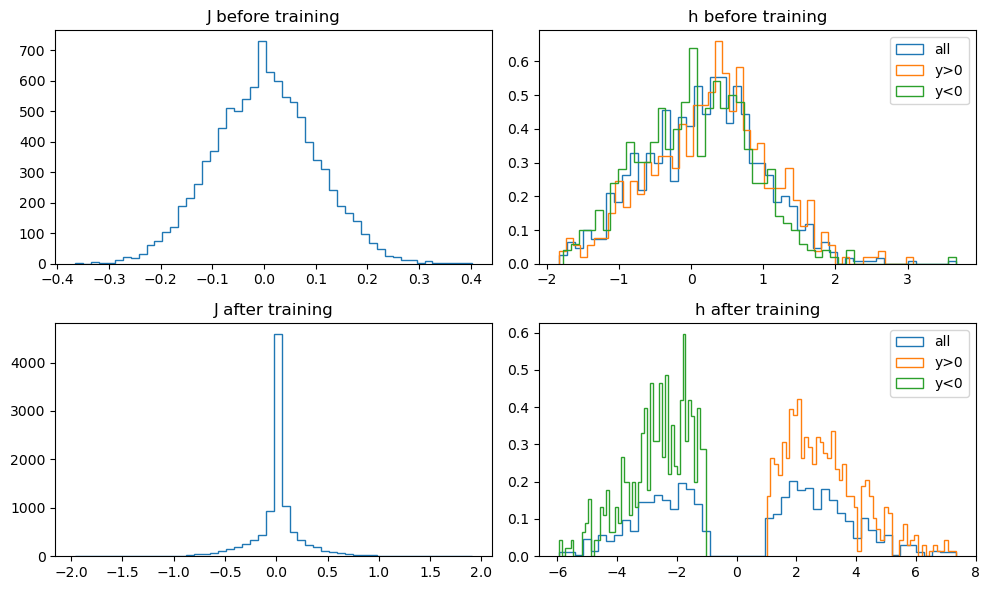

In [10]:
plt.figure(figsize=(10,6))

# before training
Hs0 = X @ J0.T + I[None]
delta_minus0 = np.max(Hs0[Y<0])
delta_plus0 = np.min(Hs0[Y>0])
print("Before training:")
print("delta_minus:", delta_minus0)
print("delta_plus:", delta_plus0)

plt.subplot(221)
plt.hist(J0.flatten(), bins=50, histtype="step");
plt.title('J before training')
plt.subplot(222)
plt.hist(Hs0.flatten(), bins=50, density=True, histtype="step", label='all');
plt.hist(Hs0[Y>0], bins=50, density=True, histtype="step", label='y>0');
plt.hist(Hs0[Y<0], bins=50, density=True, histtype="step", label='y<0');
plt.title('h before training')
plt.legend();

# after training
Hs = X @ J.T + I[None]
delta_minus = np.max(Hs[Y<0])
delta_plus = np.min(Hs[Y>0])
print("\nAfter training:")
print("delta_minus:", delta_minus)
print("delta_plus:", delta_plus)

plt.subplot(223)
plt.hist(J.flatten(), bins=50, histtype="step");
plt.title('J after training')
plt.subplot(224)
plt.hist(Hs.flatten(), bins=50, density=True, histtype="step", label='all');
plt.hist(Hs[Y>0], bins=50, density=True, histtype="step", label='y>0');
plt.hist(Hs[Y<0], bins=50, density=True, histtype="step", label='y<0');
plt.title('h after training')
plt.legend();

plt.tight_layout();

### Effective signs for the recurrent weights

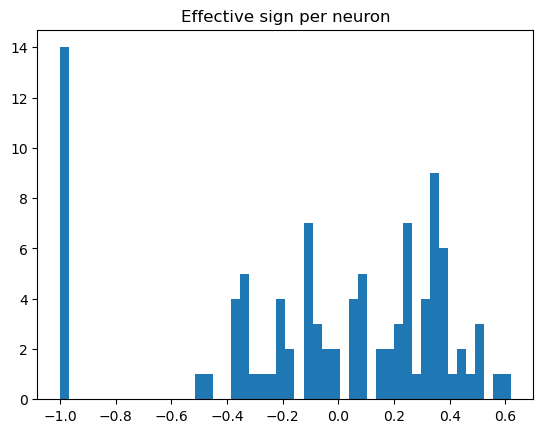

fe_eff: 0.52
J_eff:
[[ 0.13267304 -0.12691687]
 [ 0.14206292 -0.15299971]]
I_eff:
[-0.00769231  0.27083334]


In [11]:
## Poorly defined quantity: must probably find a better one that filters out zero weights
signJ = (2. * (J > 0.) - 1.).mean(0)

if fe > 0:
    indE = range(Ne)
    indI = range(Ne,N)
else:
    indE = np.arange(N)[signJ > 1e-6]
    indI = np.arange(N)[signJ <= 1e-6]

# plt.plot(signJ, '.-');
plt.hist(signJ, bins=50);
plt.title('Effective sign per neuron')
plt.show()
    
Ne_eff = (signJ>0).sum()
Ni_eff = N - Ne_eff
fe_eff = Ne_eff / N
print('fe_eff:', fe_eff)


JEE = J[indE][:,indE]
JEI = J[indE][:,indI]
JIE = J[indI][:,indE]
JII = J[indI][:,indI]

J_eff = np.array([[JEE.mean(), JEI.mean()],
                 [JIE.mean(), JII.mean()]])
print("J_eff:")
print(J_eff)

I_eff = np.array([I[indE].mean(), I[indI].mean()])
print("I_eff:")
print(I_eff)

if embed_model:
    plt.subplot(121)
    plt.imshow(J, origin='upper');
    plt.title('J')
    plt.subplot(122)
    plt.imshow(np.abs(J), origin='upper');
    plt.title('abs(J)')
    plt.tight_layout();
    plt.show()

    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=3, c='red')
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=3, c='blue')
        plt.show()
    else:
        plt.imshow(np.sign(signJ).reshape(lN,lN))

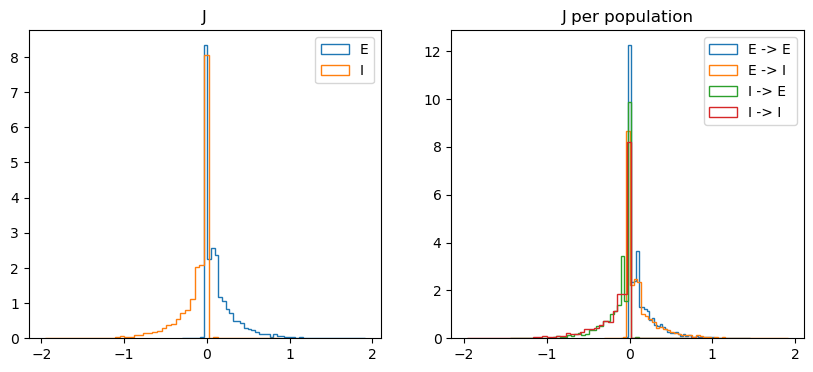

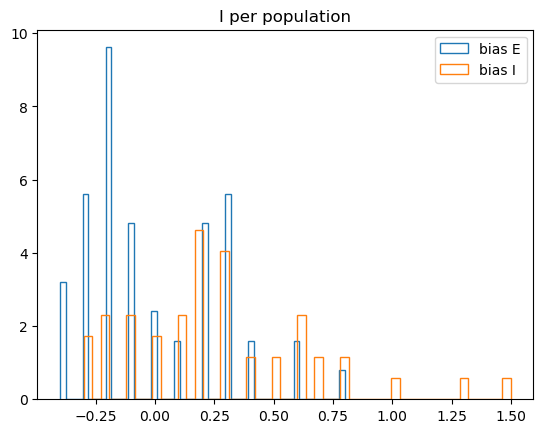

In [12]:
# weights per population

if fe == -1 and not gam_sign:
    plt.hist(J.flatten(), bins=50, density=True, histtype="step", label='J');
#     plt.hist(I, bins=50, density=True, histtype="step", label='bias');
    plt.legend();
else:
    plt.figure(figsize=(10,4))
    
    plt.subplot(121)
    plt.hist(J[:,indE].flatten(), bins=50, density=True, histtype="step", label='E');
    plt.hist(J[:,indI].flatten(), bins=50, density=True, histtype="step", label='I');
    plt.title('J')
    plt.legend()

    plt.subplot(122)
    plt.hist(J[indE][:,indE].flatten(), density=True, bins=50, histtype="step", label="E -> E");
    plt.hist(J[indI][:,indE].flatten(), density=True, bins=50, histtype="step", label="E -> I");
    plt.hist(J[indE][:,indI].flatten(), density=True, bins=50, histtype="step", label="I -> E");
    plt.hist(J[indI][:,indI].flatten(), density=True, bins=50, histtype="step", label="I -> I");
    plt.title('J per population')
    plt.legend();
    
    plt.show()
    plt.hist(I[indE], bins=50, density=True, histtype="step", label='bias E');
    plt.hist(I[indI], bins=50, density=True, histtype="step", label='bias I');
    plt.title('I per population')
    plt.legend();

### Look at receptive and projective fields

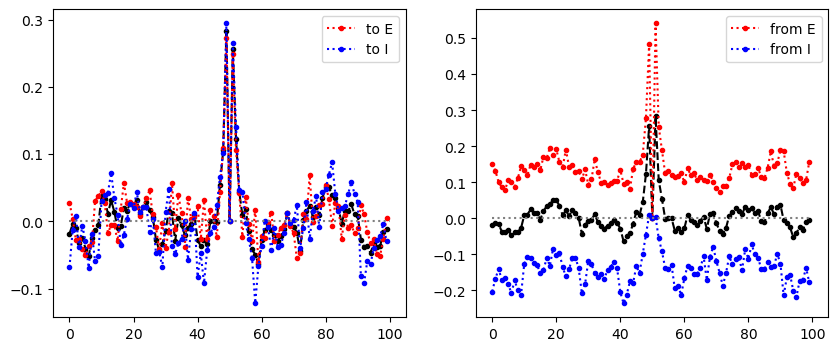

In [13]:
Jmeanto = np.zeros(N)
Jmeanfrom = np.zeros(N)
JmeantoE = np.zeros(N)
JmeantoI = np.zeros(N)
JmeanfromE = np.zeros(N)
JmeanfromI = np.zeros(N)
for k in range(N):
    Jmeanto += np.roll(J[k], -k+N//2) * 1/N
    Jmeanfrom += np.roll(J[:,k], -k+N//2) * 1/N
    if k in indE:
        JmeantoE += np.roll(J[k], -k+N//2) / Ne_eff
        JmeanfromE += np.roll(J[:,k], -k+N//2) / Ne_eff
    if k in indI:
        JmeantoI += np.roll(J[k], -k+N//2) / Ni_eff
        JmeanfromI += np.roll(J[:,k], -k+N//2) / Ni_eff
    
plt.figure(figsize=(10,4))

if dim == 1:
    plt.subplot(121)
    plt.plot(Jmeanto, '.--', c='k', );
    plt.plot(JmeantoE, '.:', c='red', label='to E');
    plt.plot(JmeantoI, '.:', c='blue', label='to I');
    plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');
    plt.legend();

    plt.subplot(122)
    plt.plot(Jmeanfrom, '.--', c='k');
    plt.plot(JmeanfromE, '.:', c='red', label='from E');
    plt.plot(JmeanfromI, '.:', c='blue', label='from I');
    plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');

    plt.legend();
else:
    plt.subplot(231)
    plt.imshow(Jmeanto.reshape(lN,lN))
    plt.subplot(232)
    plt.imshow(JmeantoE.reshape(lN,lN))
    plt.subplot(233)
    plt.imshow(JmeantoI.reshape(lN,lN))
    
    plt.subplot(234)
    plt.imshow(Jmeanfrom.reshape(lN,lN))
    plt.subplot(235)
    plt.imshow(JmeanfromE.reshape(lN,lN))
    plt.subplot(236)
    plt.imshow(-JmeanfromI.reshape(lN,lN))

### Receptive fields in space

In [14]:
if embed_model:
    ind = 10
    # k = indE[ind]
    k = indI[ind]
    # k = ind
    print("neuron:", k)
    print("sign:", signJ[k])
    color = "red" if signJ[k] > 0 else "blue"

    plt.figure(figsize=(10,4))

    plt.subplot(121)
    plt.title('projective field')
    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=5, c='red', alpha=0.2)
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=5, c='blue', alpha=0.2)
        plt.plot(pos[k], 0, 'o', c=color, alpha=0.4);
        plt.plot(J[:,k], '.-', alpha=0.9, c='gray')
    else:
        plt.plot(pos[k,1], pos[k,0], 'o', c=color);
        plt.imshow(np.abs(J[:,k]).reshape(lN,lN))

    plt.subplot(122)
    plt.title('receptive field')
    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=4, c='red', alpha=0.2)
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=4, c='blue', alpha=0.2)
        plt.plot(pos[k], 0, 'o', c=color, alpha=0.4);
        plt.plot(J[k], '.-', alpha=0.9, c='gray');
    else:
        plt.plot(pos[k,1], pos[k,0], 'o', c=color);
        plt.imshow(J[k].reshape(lN,lN));

    plt.tight_layout();

### Look at E and I populations separately

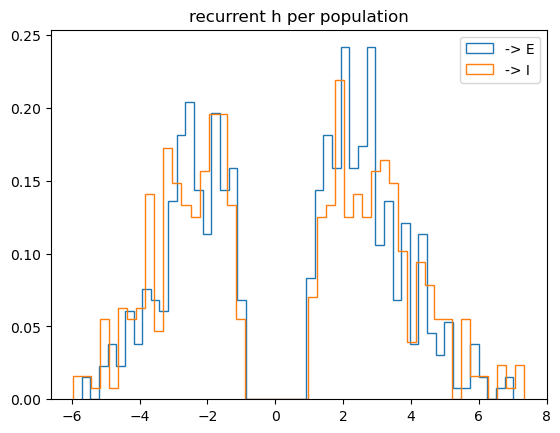

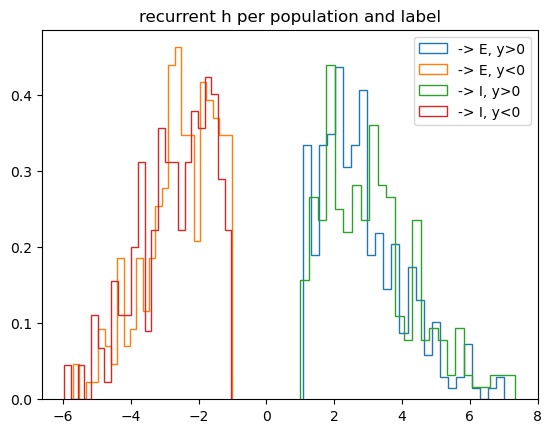

In [15]:
# fields per population
HfromE = X[:,indE] @ J[:,indE].T
HfromI = X[:,indI] @ J[:,indI].T

plt.hist(Hs[:,indE].flatten(), bins=50, density=True, histtype="step", label='-> E');
plt.hist(Hs[:,indI].flatten(), bins=50, density=True, histtype="step", label='-> I');
plt.title('recurrent h per population')
plt.legend();
plt.show();

plt.hist(Hs[:,indE][Y[:,indE]>0].flatten(), bins=25, density=True, histtype="step", label='-> E, y>0');
plt.hist(Hs[:,indE][Y[:,indE]<0].flatten(), bins=25, density=True, histtype="step", label='-> E, y<0');
plt.hist(Hs[:,indI][Y[:,indI]>0].flatten(), bins=25, density=True, histtype="step", label='-> I, y>0');
plt.hist(Hs[:,indI][Y[:,indI]<0].flatten(), bins=25, density=True, histtype="step", label='-> I, y<0');
plt.title('recurrent h per population and label')
plt.legend();
plt.show();

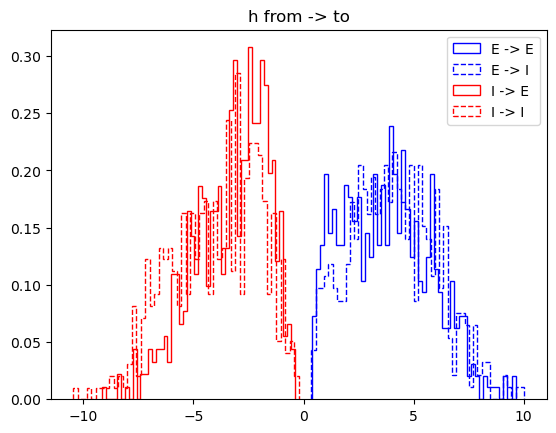

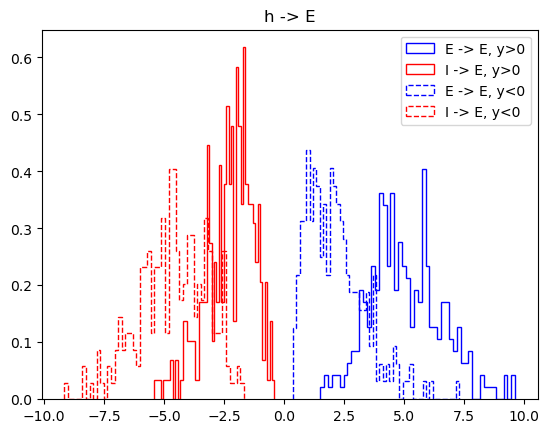

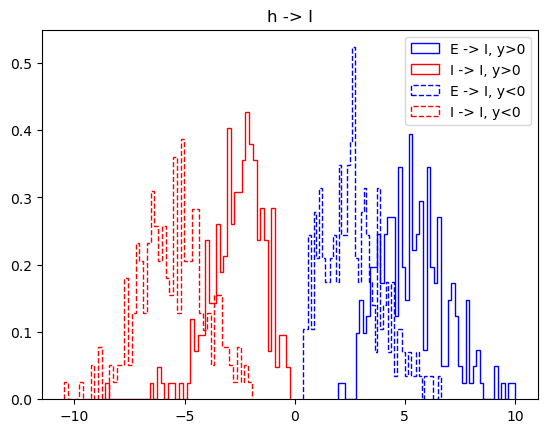

In [16]:
# fields per channel
plt.hist(HfromE[:,indE].flatten(), bins=50, density=True, histtype="step", label='E -> E', color='blue');
plt.hist(HfromE[:,indI].flatten(), bins=50, density=True, histtype="step", label='E -> I', color='blue', ls='--');
plt.hist(HfromI[:,indE].flatten(), bins=50, density=True, histtype="step", label='I -> E', color='red');
plt.hist(HfromI[:,indI].flatten(), bins=50, density=True, histtype="step", label='I -> I', color='red', ls='--');
plt.title('h from -> to')
plt.legend();
plt.show()

## fields to E per label
plt.hist(HfromE[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> E, y>0');
plt.hist(HfromI[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> E, y>0');
plt.hist(HfromE[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> E, y<0');
plt.hist(HfromI[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> E, y<0');
plt.title('h -> E')
plt.legend();
plt.show()

## fields to I per label
plt.hist(HfromE[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> I, y>0');
plt.hist(HfromI[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> I, y>0');
plt.hist(HfromE[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> I, y<0');
plt.hist(HfromI[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> I, y<0');
plt.title('h -> I')
plt.legend();
plt.show()